# Classification of b-quark jets in the Aleph simulated data

The following is an introduction to using Machine Learning (ML) - in particular Boosted Decision Trees (BDT) - for trying to determine, if an entry in a data file is of one type (signal, ill, guilty, etc.) or another (background, healthy, innocent, etc.).

You may choose between two data samples:
1. A particle physics dataset containing simulated decays of the $Z^0$ boson decaying to a quark and an anti-quark producing two "jets" of particles. The question is, if the jets are from a b-quark (b-jet) or from lighter quarks (l-jet).
3. A "medical" dataset which concers a lifestyle disease in relation to various (transformed) lifestyle variables (reduced in number of variables to match the Aleph b-jet data set).

In the following, we discuss the problem from the b-jet point of view, as this is where the largest size datasets are available. However, we stress that from the point of view of ML, data content (what is being considered) is not essential to know (for now!!!). And knowing the content in details requires domain knowledge, i.e. that you are an expert in the specific field, that the data comes from. This part is very important, but not the focus in this course.

In the end, this exercise is the simple start "outside ML" and moving into the territory of Machine Learning analysis.

### The Data:
The input variables (X) are (used by Aleph for their NN):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

Auxilary variables (Z) are (not used by Aleph for their NN):
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the Aleph detector was essentially uniform in phi, this should not matter (much).

The target variable (Y) is:
* **isb**:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* **nnbjet**: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).

In case you choose **the medical data**, the variables to use as input (X) are: **Qsocial, BMI, Roccupat, Rgenetic, Rdietary, and Rhormonn** (reflecting Quantiles and Ratios of medical measurements). The target variable (Y) is (naturally): **TrulyIll**, and you can compare your results to the average of doctors: **DocScore**.


## The Task: Input Feature Ranking (here for LightGBM model):

The following exercise is about Input Feature Ranking. Your task is to give an overview out of the importance of each variable in the model, and their respective contribution to the models perfomance.



* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   15th of April 2025

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np

SavePlots = False

## Import and inspect the data:

In [2]:
# Read the data and print the variables:
data = pd.DataFrame(np.genfromtxt('../Week1/AlephBtag_MC_train_Nev50000.csv', names=True))
# data = pd.DataFrame(np.genfromtxt('../Week1/Medical_Npatients50000.csv', names=True))

variables = data.columns
print(variables.values)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables.values)

['energy' 'cTheta' 'phi' 'prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet'
 'ptlrel' 'nnbjet' 'isb']
  Variables used for training:  ['prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet' 'ptlrel']


***

# Classification using LightGBM:


This is a solution example using LightGBM (tree based).

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
import time

start=time.time()

# Split data set into training and test set. We choose a 75:25 division here. 

# Dataset is shuffeled before the split (to avoid any ordering). By using a fixed
# random seed number (42), we can rerun and obtain the same result (for reproducibility!).
X_train, x_test, Y_train, y_test, benchmark_train, benchmark_test = \
    train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)

# Feed the datasets to LightGBM:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(x_test,  y_test, reference=lgb_train)

# Set parameters for LightGBM (known more generally as "hyper parameters"):
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'num_leaves': 6,         # Set a maximum tree leaves to avoid overfitting
    'verbose': 1,            # Level of output. Can be set to -1 to suppress the output
}

# Train the model:
gbm = lgb.train(params,                             # General settings (defined above)
                lgb_train,                          # Data to use for training
                num_boost_round=1000,               # How many rounds for training
                valid_sets=lgb_eval,                # Data to use for validation
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N=20 rounds.

# Make predictions.
# NOTE the difference between 'score' (continuous in ]0,1[) and 'predictions' (integer: 0 or 1):
# Also NOTE that you can choose where to set the threshold (here set to 0.1)
y_score = gbm.predict(x_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.
y_pred  = [1 if pred > 0.1 else 0 for pred in y_score]               # Classify b-quark yes or no (for comparison). 

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

[LightGBM] [Info] Number of positive: 8464, number of negative: 29036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225707 -> initscore=-1.232715
[LightGBM] [Info] Start training from score -1.232715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.244462
Time used by LightGBM: 1956.8 ms


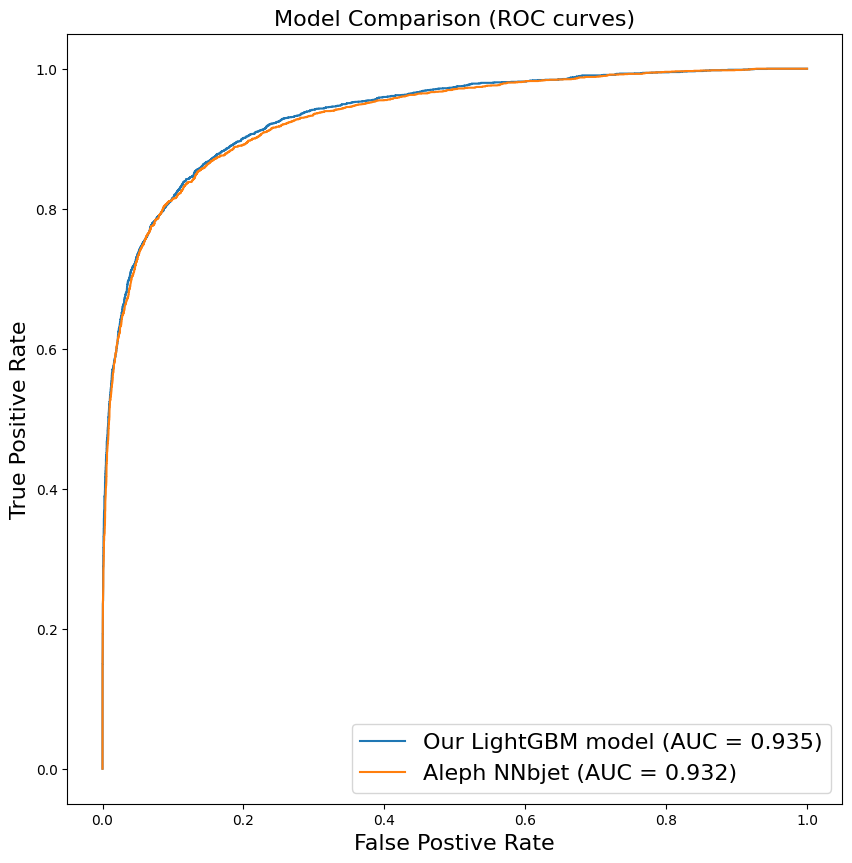

In [4]:
# Evaluate:
fpr, tpr, _ = roc_curve(y_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(y_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the Area-Under-the-Curve (AUC) scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model Comparison (ROC curves)', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.show()

## Questions:

1. Try to determine an input feature ranking first by using the **build-in function** for this in LightGBM. Yes, look at the documentation and find the one line of code that does this. Can you also find - and understand - the description of how it reaches these results?

2. Now try to get an input feature ranking using **permutation invariance**. Think of an ML package that contains a lot of different ML tools, and check if this package does not have a tool for doing so. Do you get a similar ranking as for the above method?

3. Finally, calculate SHAP values and use these (using $\sum_i |SHAP_i |$) to determine a ranking of the input features. Again, compare it to the two above. Do they agree?

4. Try to rerun the model twice with only 5 input parameters: Missing the highest and lowest ranking feature. Do you see a significant difference in the performance between these two cases? And how about when comparing to the 6 input feature case?


## Learning points:

1. You should first of all understand the concept of “feature ranking”.

2. You should also be capable of determining the feature ranking for a given algorithm in multiple ways, specifically using permutation invariance (PI) and SHAP values.

3. Finally, you should understand that while PI and other build-in methods gives an average input feature ranking, the SHAP values are capable of giving an individual input feature ranking for each case.


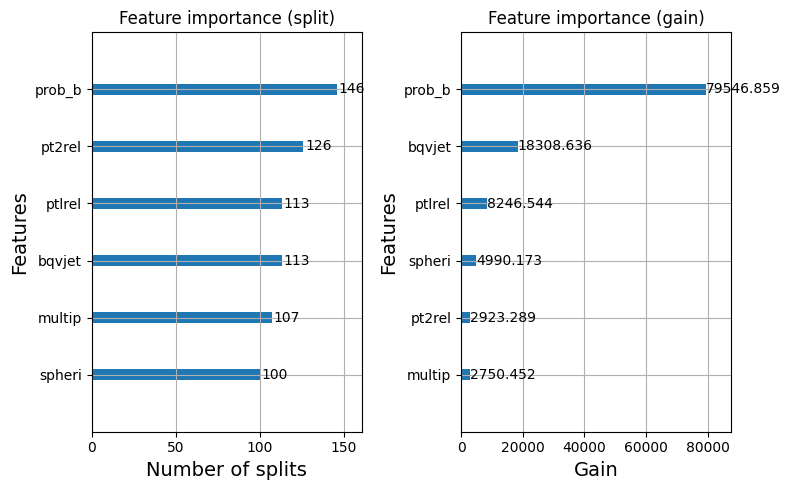

In [13]:
# Feature ranking in LightGBM:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Plot importance by split
lgb.plot_importance(gbm, max_num_features=10, importance_type='split', ax=axes[0], title='Feature importance (split)')
axes[0].set_xlabel('Number of splits', size=14)
axes[0].set_ylabel('Features', size=14)

# Plot importance by gain
lgb.plot_importance(gbm, max_num_features=10, importance_type='gain', ax=axes[1], title='Feature importance (gain)')
axes[1].set_xlabel('Gain', size=14)
axes[1].set_ylabel('Features', size=14)

plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 6
[LightGBM] [Info] Start training from score 0.225707


/tmp/ipykernel_29421/1730885711.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])


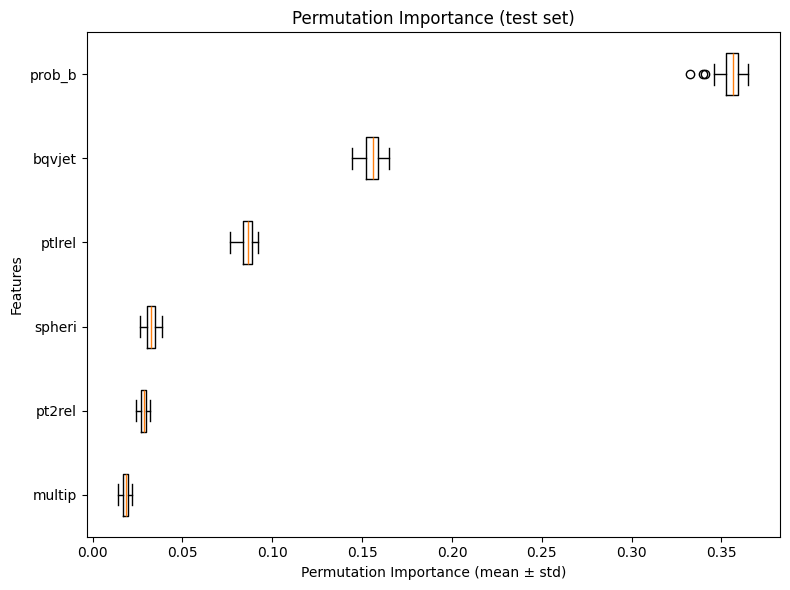

In [ ]:
from sklearn.inspection import permutation_importance
gbm = lgb.LGBMRegressor()


# Calculate permutation importance
perm_importance = permutation_importance(gbm.fit(X_train, Y_train), x_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])
ax.set_title("Permutation Importance (test set)")
ax.set_xlabel("Permutation Importance (mean ± std)")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

Here we plot the SHAP values next. As always, **any nice feature you can think of has probably already been implemented**. Try changing the plot_type to the plot type you like best.
Options include: `violin`, `dot`, `bar`
I personaly like the violin plot, but the bar plot probably gives a more simple picture of the ranking of importance

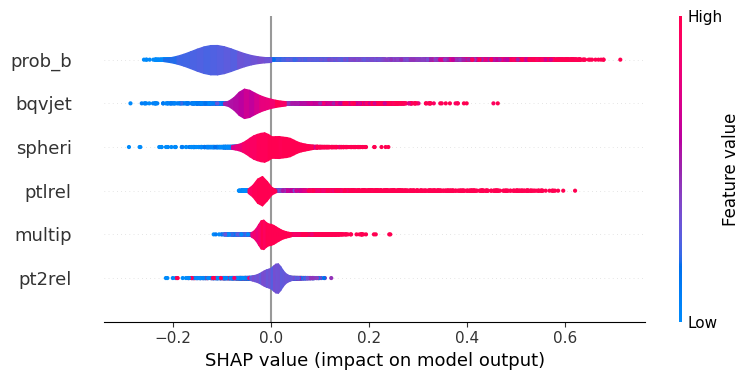

In [28]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(x_test)
# Plot SHAP values
shap.summary_plot(shap_values, x_test, feature_names=input_variables, plot_type="violin", max_display=10)
plt.show()


Let's train two models using only the top 5 / bottom 5 features and compare their performance
(I didn't optimize the HP's, but the trend should hold)

In [31]:
# Make new selections based on top/bottom 5 variables
top_5_input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi') & (variables != 'pt2rel')]
bottom_5_input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi') & (variables != 'prob_b')]

input_data_top_5      = data[top_5_input_variables]
input_data_bottom_5   = data[bottom_5_input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']

# Train and evaluate the model using the top 5 variables
X_train_top, x_test_top, Y_train_top, y_test_top = \
    train_test_split(input_data_top_5, truth_data, test_size=0.25, random_state=42)

lgb_train_top = lgb.Dataset(X_train_top, Y_train_top)
lgb_eval_top = lgb.Dataset(x_test_top, y_test_top, reference=lgb_train_top)

gbm_top = lgb.train(params, lgb_train_top, num_boost_round=1000, valid_sets=lgb_eval_top, callbacks=[early_stopping(20)])

y_score_top = gbm_top.predict(x_test_top, num_iteration=gbm_top.best_iteration)
y_pred_top = [1 if pred > 0.1 else 0 for pred in y_score_top]

# Train and evaluate the model using the bottom 5 variables
X_train_bottom, x_test_bottom, Y_train_bottom, y_test_bottom = \
    train_test_split(input_data_bottom_5, truth_data, test_size=0.25, random_state=42)

lgb_train_bottom = lgb.Dataset(X_train_bottom, Y_train_bottom)
lgb_eval_bottom = lgb.Dataset(x_test_bottom, y_test_bottom, reference=lgb_train_bottom)

gbm_bottom = lgb.train(params, lgb_train_bottom, num_boost_round=1000, valid_sets=lgb_eval_bottom, callbacks=[early_stopping(20)])

y_score_bottom = gbm_bottom.predict(x_test_bottom, num_iteration=gbm_bottom.best_iteration)
y_pred_bottom = [1 if pred > 0.1 else 0 for pred in y_score_bottom]

# Print results
print("Model trained with top 5 variables:")
print(f"AUC Score: {auc(roc_curve(y_test_top, y_score_top)[0], roc_curve(y_test_top, y_score_top)[1]):.3f}")

print("\nModel trained with bottom 5 variables:")
print(f"AUC Score: {auc(roc_curve(y_test_bottom, y_score_bottom)[0], roc_curve(y_test_bottom, y_score_bottom)[1]):.3f}")

[LightGBM] [Info] Number of positive: 8464, number of negative: 29036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225707 -> initscore=-1.232715
[LightGBM] [Info] Start training from score -1.232715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.249413
[LightGBM] [Info] Number of positive: 8464, number of negative: 29036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 5
[LightGBM] [I

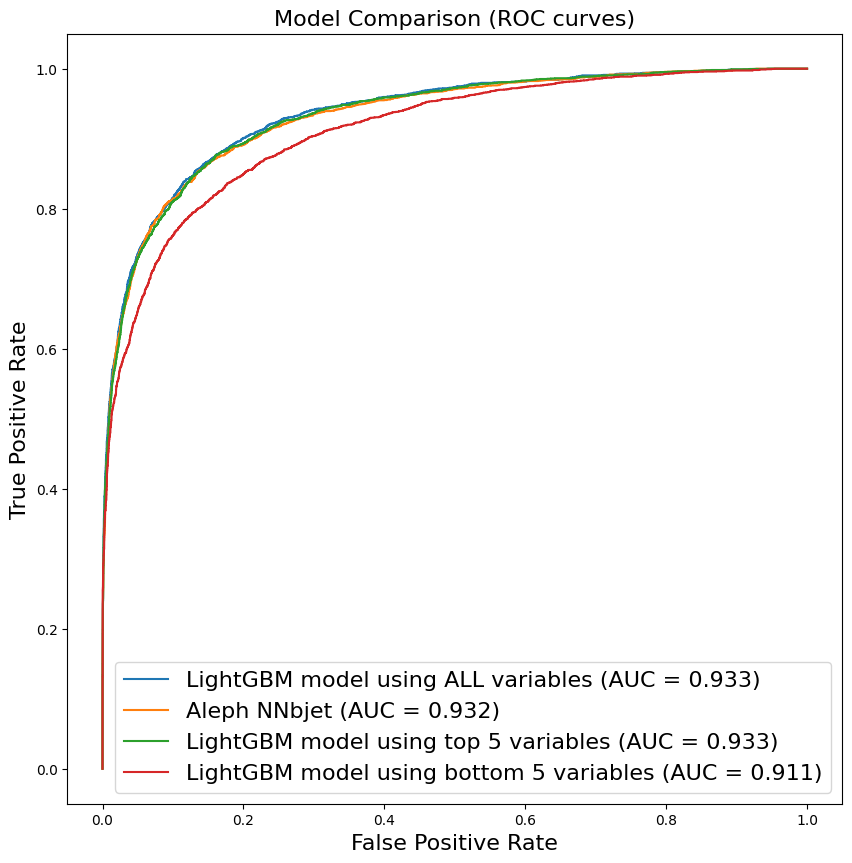

In [33]:
# Evaluate bottom / top 5
fpr_top, tpr_top, _ = roc_curve(y_test_top, y_score_top)
fpr_bottom, tpr_bottom, _ = roc_curve(y_test_bottom, y_score_bottom)

# We can now calculate the Area-Under-the-Curve (AUC) scores of these ROC-curves:
auc_score_top = auc(fpr_top, tpr_top)                        # This is the AUC score for the top 5 model
auc_score_bottom = auc(fpr_bottom, tpr_bottom)              # This is the AUC score for the bottom 5 model

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize=[10, 10])
plt.title('Model Comparison (ROC curves)', size=16)
plt.plot(fpr, tpr, label=f'LightGBM model using ALL variables (AUC = {auc_score_top:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label=f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.plot(fpr_top, tpr_top, label=f'LightGBM model using top 5 variables (AUC = {auc_score_top:5.3f})')
plt.plot(fpr_bottom, tpr_bottom, label=f'LightGBM model using bottom 5 variables (AUC = {auc_score_bottom:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Positive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.show()
